####Feature Selection
Provided that the main goal of the project is to reduce the number of features in final prediction model and keep the model's accuracy at a high level at the same time, feature selection becomes the first step to acchieve the ultimate objective. The initial strategy for feature selection is to take advantage of Randome Forest Classifier (RFC) technique and its ability to rank features in terms of their respective importance in the model. However, it is quickly found that the top five features ranked by the RFC are highly correlerated to each other. The high correlation of many features is mainly due to the data pre-processing procedure in which sampling points are allowed to overlap each other.

In order to detect features that are most distinct to each other, a combination of Recursive Feature Elimination (RFE) technique and Greed Method is adopted. The strategy is as follows: the RFE narrows down the number of feature candidates to speed up selection process; and then Greed Method apptempts to find the best combination of a fixed number of features, which is five in the case of this project. 

More specifically, the recursive feature elimination technique first use all features to fit a classifier model on the train data to see its performance, and then it erase a certain amount of features that do not contribute much in the previous model, and fit a model again to see the new model's performance. The technique repeat the selection process untill it finds the optimal number of features for the final model. In addtion, the classifier model here is vector support machine, an algorithm whose goal is to separate classes by drawing a line as wide as possible between them.

After narrowing down features to 81, Greed Method is implemented to find an optimal combination of five features.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Import the `RandomForestClassifier`
from sklearn.ensemble import RandomForestClassifier

In [5]:
directory = 'UCI HAR Dataset/train/X_train.txt'
sub_dir = 'UCI HAR Dataset/train/subject_train.txt'
y_dir = 'UCI HAR Dataset/train/y_train.txt'
train = np.loadtxt(directory)
train_subject = np.loadtxt(sub_dir)
train_y = np.loadtxt(y_dir)

In [6]:
directory = 'UCI HAR Dataset/test/X_test.txt'
sub_dir = 'UCI HAR Dataset/test/subject_test.txt'
y_dir = 'UCI HAR Dataset/test/y_test.txt'
test = np.loadtxt(directory)
test_subject = np.loadtxt(sub_dir)
test_y = np.loadtxt(y_dir)

In [75]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                           n_redundant=2, n_repeated=0, n_classes=8,
#                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=KFold(2),
              scoring='accuracy')
rfecv.fit(train, train_y)

RFECV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 81


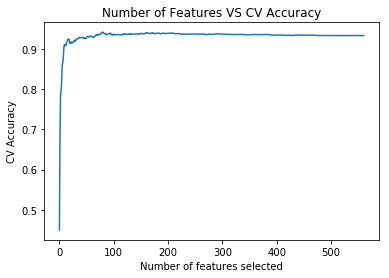

In [77]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title('Number of Features VS CV Accuracy')
plt.xlabel("Number of features selected")
plt.ylabel("CV Accuracy")
plt.plot(range(0, 561, 1), rfecv.grid_scores_)
plt.show()

In [78]:
#retrieve feature index in the original training dataset
features = []
for i in range(len(rfecv.support_)):
    if rfecv.support_[i]:
        features.append(i)

In [85]:
len(features)

81

In [79]:
reduced_train = train[:,rfecv.support_]

In [80]:
reduced_train.shape

(7352L, 81L)

In [81]:
#use cross validation and repeated random forest process to pick final features
final_scores = np.zeros(reduced_train.shape[1])
# for each cross validation set k fold, where k = 10
# repeat random forest process for n times, store importances scores into a list, n = 10
K = 1; N = 10;
for k in range(K):
    #subjects = list(set(train_subject))
    #sample = np.array([subjects[k], subjects[k+10]])
    #indx = np.array([x in sample for x in train_subject])
    #tn = reduced_train[indx != True]
    #tn_y = train_y[indx != True]
    #cv = reduced_train[indx]
    #cv_y = train_y[indx]
    for n in range(N):
        state = int(np.random.rand(1)*1000)
        #random forest
        forest = RandomForestClassifier(max_depth = None,
                                        min_samples_split=5,
                                        n_estimators = 1000,
                                        random_state = state,
                                        bootstrap = True, oob_score = True)
        my_forest = forest.fit(reduced_train, train_y)
        print "oob score: ", str(my_forest.oob_score_)
        final_scores += my_forest.feature_importances_
final_scores = final_scores/(K*N)


oob score:  0.980549510337
oob score:  0.980957562568
oob score:  0.979733405876
oob score:  0.979597388466
oob score:  0.980957562568
oob score:  0.981093579978
oob score:  0.980821545158
oob score:  0.981093579978
oob score:  0.980413492927
oob score:  0.980413492927


In [94]:
#feature selection, greed method
#sort features by importance scores,
#pick the most important feature,
#try every pair of this feature with each of other features, pick the best pair according to accuracy
#with two-feature group picked, repeat the process to find the third one.
#stop until five features are selected.
cv_fold = 10
subjects = list(set(train_subject))
K = 10
importances = list(final_scores)
s = sorted(importances, reverse = True)
best_feature =features[importances.index(s[0])]
best_group = [best_feature]


for k in range(K):
    #best_accuracy = 0.
    group = best_group
    features_dict = dict()
    for i in range(cv_fold):
        sample = subjects[i*2:i*2+2]
        #sample = np.random.choice(subjects, 2)
        indx = np.array([x in sample for x in train_subject])
        tn = train[indx != True]
        tn_y = train_y[indx != True]
        cv = train[indx]
        cv_y = train_y[indx]
        next_best_feature = None
        best_sub_accuracy = 0.
        for feature in features:
            if feature != best_feature:
                reduced_tn = tn[:,group+[feature]]
                forest = RandomForestClassifier(max_depth = None, min_samples_split=10,
                                                n_estimators = 50, random_state = 1)
                my_forest = forest.fit(reduced_tn,tn_y)
                reduced_cv = cv[:,group+[feature]]
                score = my_forest.score(reduced_cv,cv_y)
                if score > best_sub_accuracy:
                    best_sub_accuracy = score
                    next_best_feature = feature
        features_dict[next_best_feature] = features_dict.get(next_best_feature, 0) + 1
    bf = [x for x in features_dict.keys() if features_dict[x] == max(features_dict.values())][0]
    best_group += [bf]
    sample = np.random.choice(subjects, 3)
    indx = np.array([x in sample for x in train_subject])
    tn = train[indx != True]
    tn_y = train_y[indx != True]
    cv = train[indx]
    cv_y = train_y[indx]
    tn = tn[:,best_group]
    cv = cv[:,best_group]
    forest = RandomForestClassifier(max_depth = None, min_samples_split=10,
                                                n_estimators = 100, random_state = 1)
    my_forest = forest.fit(tn,tn_y)
    score = my_forest.score(cv,cv_y)
    print "score", score
    """    if best_sub_accuracy > best_accuracy:
        print "best_sub_accuracy "+str(best_sub_accuracy) + " is greater than best_accuracy " + str(best_accuracy)
    else:
        print "Warning, best_sub_accuracy is NOT greater than previous best_accuracy"""
    #best_accuracy = best_sub_accuracy
    feature_number = len(best_group)
    print "best group, number: ", str(feature_number)
    print "best features: ", best_group
    #print "best accuracy: ", best_accuracy
    
            

score 0.809171597633
best group, number:  2
best features:  [52, 504]
score 0.772893772894
best group, number:  3
best features:  [52, 504, 53]
score 0.931730769231
best group, number:  4
best features:  [52, 504, 53, 69]
score 0.839495040577
best group, number:  5
best features:  [52, 504, 53, 69, 179]
score 0.838105726872
best group, number:  6
best features:  [52, 504, 53, 69, 179, 65]
score 0.875356803045
best group, number:  7
best features:  [52, 504, 53, 69, 179, 65, 433]
score 0.913840513291
best group, number:  8
best features:  [52, 504, 53, 69, 179, 65, 433, 37]
score 0.936813186813
best group, number:  9
best features:  [52, 504, 53, 69, 179, 65, 433, 37, 21]
score 0.939306358382
best group, number:  10
best features:  [52, 504, 53, 69, 179, 65, 433, 37, 21, 3]
score 0.825214899713
best group, number:  11
best features:  [52, 504, 53, 69, 179, 65, 433, 37, 21, 3, 288]


In [97]:
import seaborn as sns

In [98]:

def draw_scatter_plot(feature_indx, data, response):
    activity = []
    for y in response:
        if y == 1.0:
            activity.append('WALKING')
        elif y == 2.0:
            activity.append('WALKING_UPSTAIRS')
        elif y == 3.0:
            activity.append('WALKING_DOWNSTAIRS')
        elif y == 4.0:
            activity.append('SITTING')
        elif y == 5.0:
            activity.append('STANDING')
        elif y == 6.0:
            activity.append('LAYING')
    indx = []
    feature_name = []
    for line in open('UCI HAR Dataset\\features.txt','r'):
        line = line.split()
        l, f = line
        indx.append(l)
        feature_name.append(f)
    chosen_feature = []
    for ind in feature_indx:
        chosen_feature.append(feature_name[ind])
    print chosen_feature
    reduced_data = pd.DataFrame(data[:, feature_indx])
    reduced_data.columns = chosen_feature
    reduced_data['activity'] = activity
    sns.set()
    sns.pairplot(reduced_data, hue='activity', size = 6)

['tGravityAcc-min()-X', 'fBodyAccMag-mad()', 'tGravityAcc-min()-Y', 'tGravityAcc-arCoeff()-Y,1', 'tBodyGyroJerk-iqr()-X']


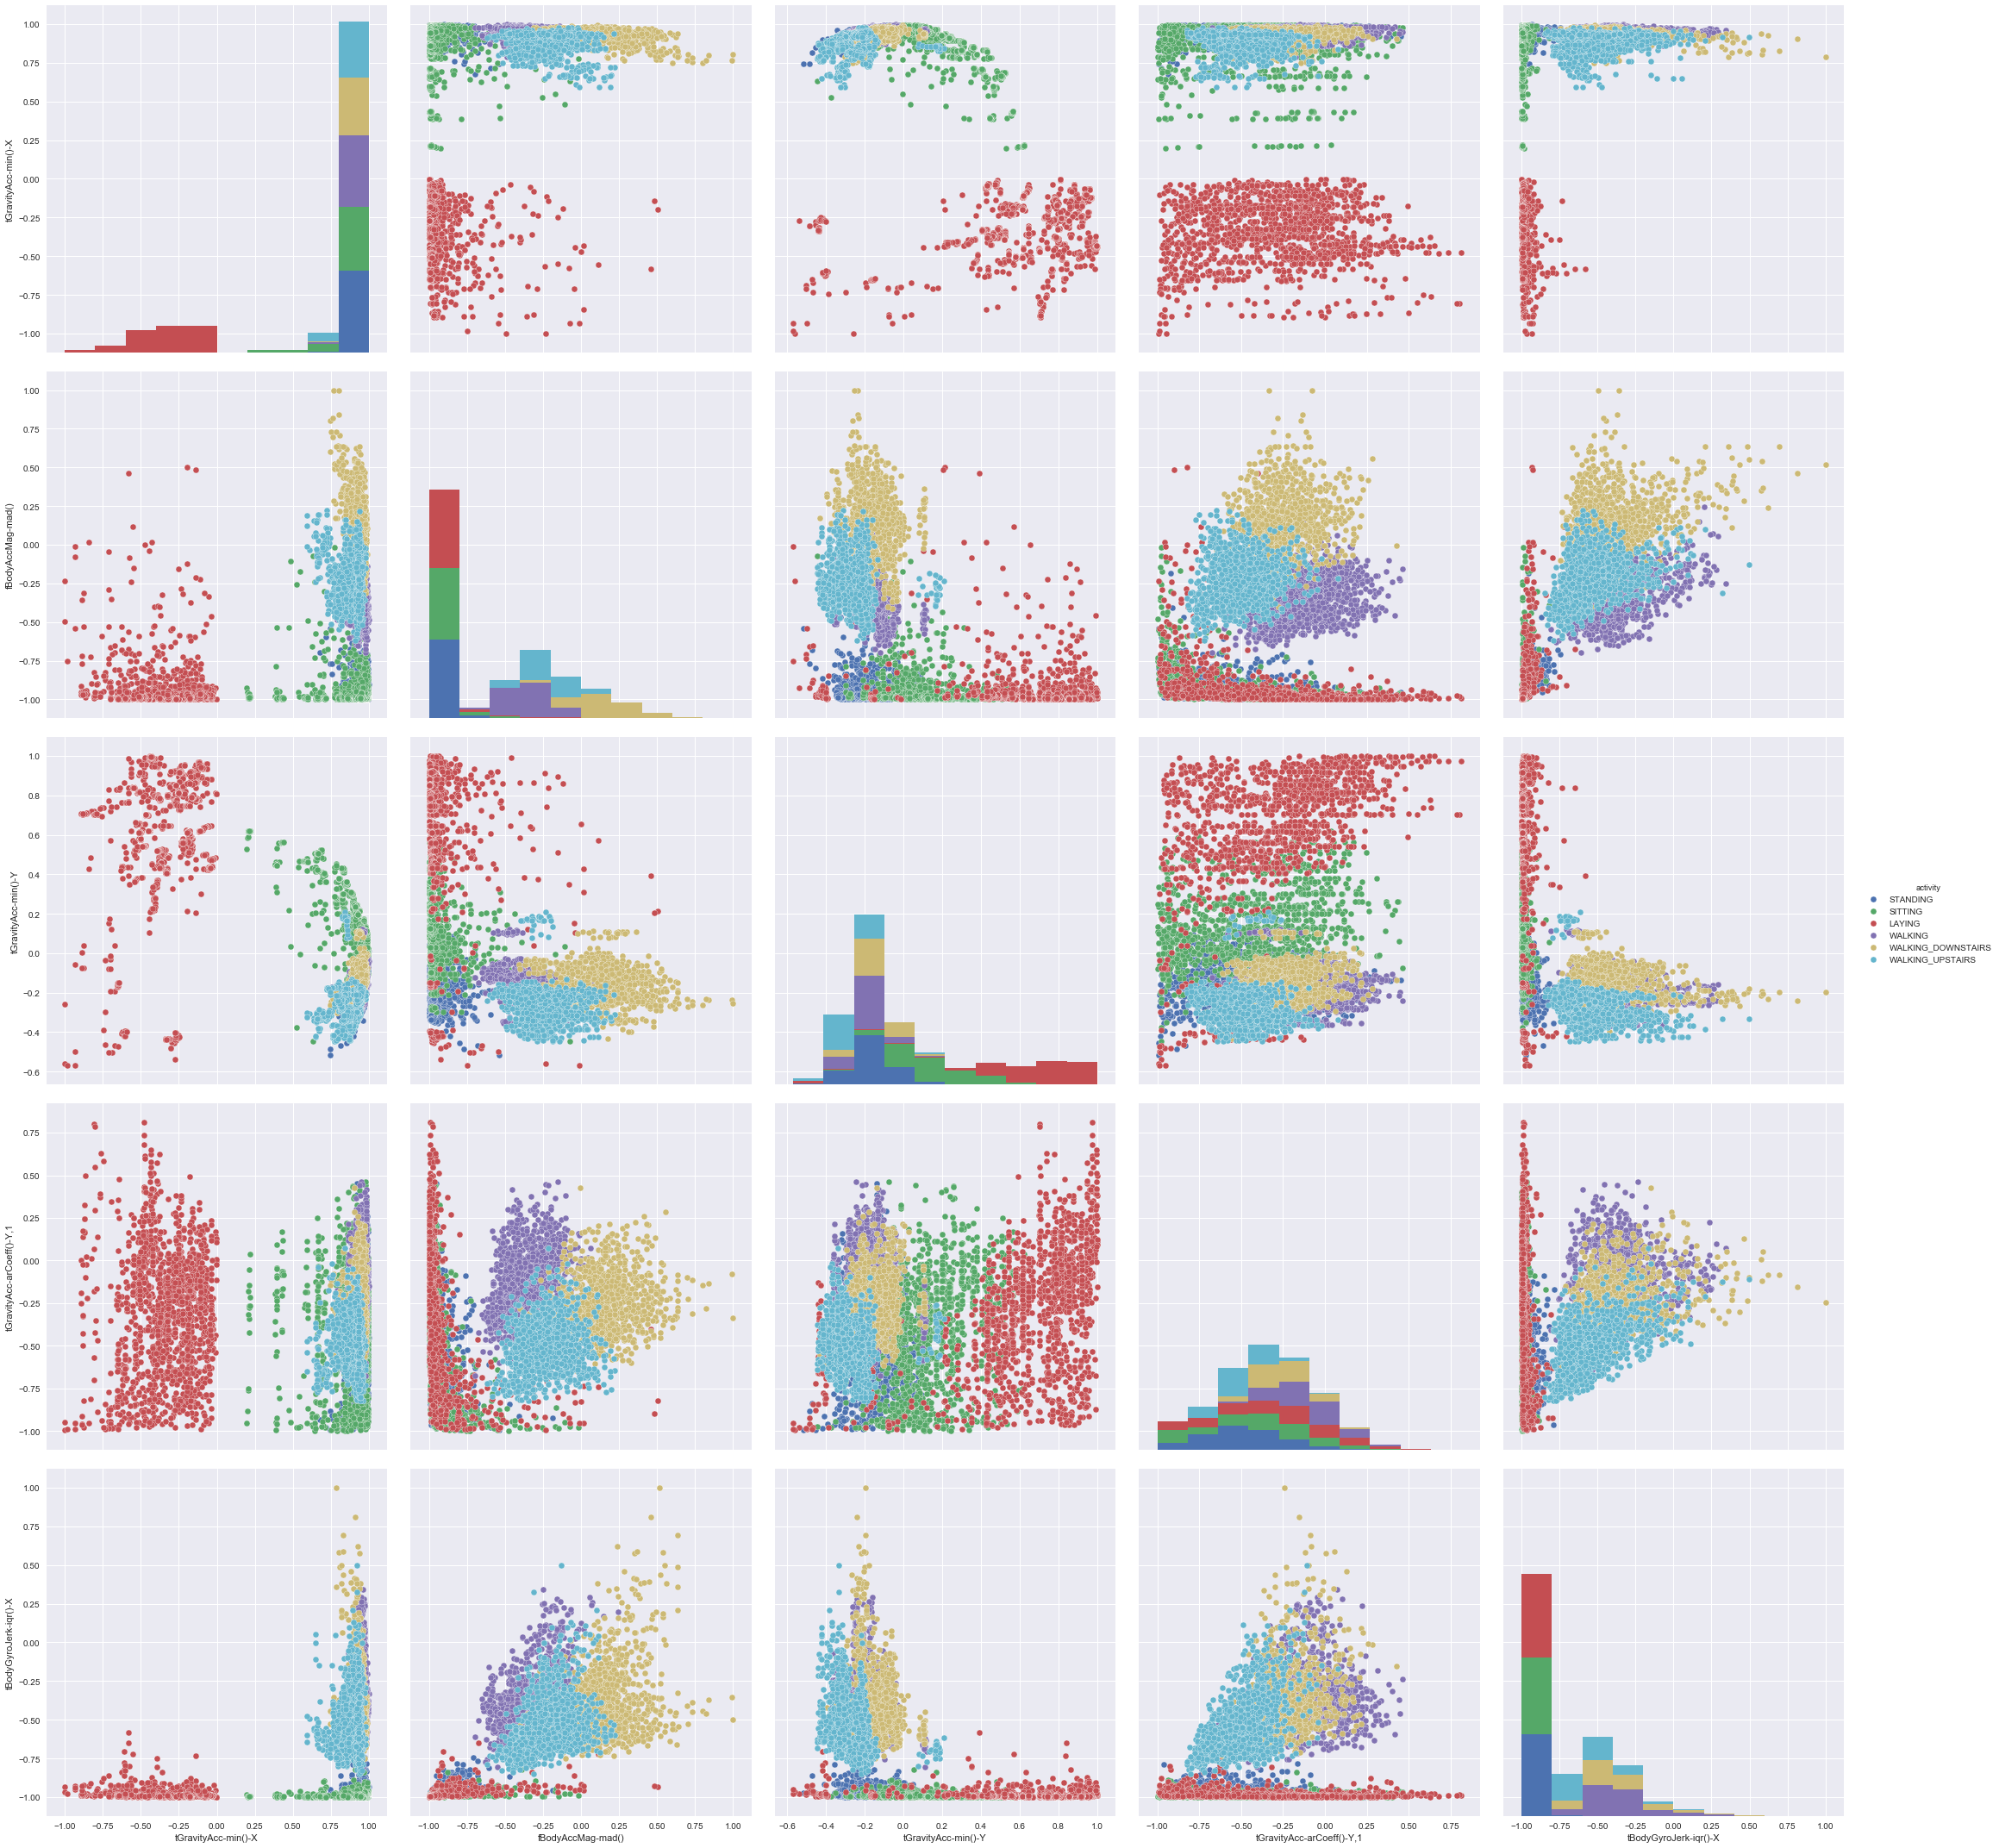

In [99]:
draw_scatter_plot([52, 504, 53, 69, 179], train, train_y)

###Modeling
Finally, we get the five important features.
['tGravityAcc-min()-X', 'fBodyAccMag-mad()', 'tGravityAcc-min()-Y', 'tGravityAcc-arCoeff()-Y,1', 'tBodyGyroJerk-iqr()-X']
Using them, we fit a random forest to the train data, and test the model on test data, getting an accuracy of 0.846. 

In [95]:
forest = RandomForestClassifier(max_depth = None, min_samples_split=5, n_estimators = 100, random_state = 1)
reduced_train = train[:,[52, 504, 53, 69, 179]]
my_reduced_forest = forest.fit(reduced_train, train_y)
reduced_test = test[:,[52, 504, 53, 69, 179]]
my_reduced_forest.score(reduced_test, test_y)

0.84560570071258911

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[431  49  16   0   0   0]
 [ 64 372  34   0   1   0]
 [ 29  55 336   0   0   0]
 [  0   2   0 356 133   0]
 [  0   1   0  71 460   0]
 [  0   0   0   0   0 537]]


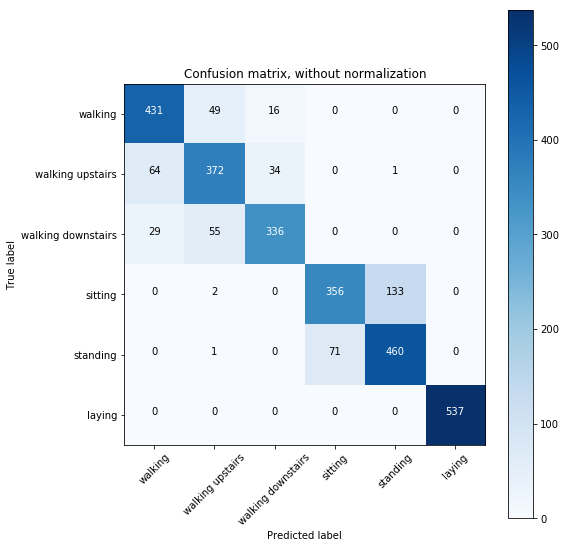

In [96]:
print(__doc__)

import itertools
from sklearn.metrics import confusion_matrix

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
class_names = ["walking","walking upstairs", "walking downstairs", "sitting", "standing", "laying"]
y_pred = my_reduced_forest.predict(reduced_test)
# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
#y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()